## Example

In this simple example, we load an image, pre-process it, and classify it with a pretrained Visual Transformer.

In [1]:
import sys

sys.path.insert(1, '/home/lj9979')

import json
from PIL import Image

import torch
from torchvision import transforms

from pytorch_pretrained_vit import ViT, BlockSparseViT

from pytorch_block_sparse import BlockSparseModelPatcher
import re

/home/lj9979/anaconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lj9979/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/lj9979/anaconda3/envs/pytorch/lib/python3.11/site-packages/bitsandbytes-0.42.0-py3.11.egg/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit mul

False
'NoneType' object has no attribute 'cadam32bit_grad_fp32'


ModuleNotFoundError: No module named 'bitsandbytes.bitsandbytes'

In [ ]:
model_name = 'B_16_imagenet1k'
model = ViT(model_name, pretrained=True)
model.to(torch.device('cuda:0'))


Missing keys when loading pretrained weights: []
Unexpected keys when loading pretrained weights: []


ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
 

In [ ]:
model_new = BlockSparseViT(model_name, pretrained=True)
# model_new.to_device(torch.device('cuda:0'))
model_new.to(torch.device('cuda:0'))

mp = BlockSparseModelPatcher()

patchables = mp.get_patchable_layers(model)

dedup_layers = []

# Pretty print the regexps: replace layer number with regexp matching numbers, and dedup them
# This is a bit specific to Roberta, but should work for most transformers, it's just for ease of reading.
for patchable in patchables:
    r = patchable["regexp"]
    r = re.sub(r'[0-9]+', '[0-9]+', r)
    if r not in dedup_layers:
        dedup_layers.append(r)
        layer = patchable['layer']
        print(f"{r}\n   => {layer.in_features}x{layer.out_features}, bias={layer.bias is not None}")



Missing keys when loading pretrained weights: ['transformer.blocks.0.attn.proj_q.sparse_weight.data', 'transformer.blocks.0.attn.proj_q.sparse_weight.cols_a', 'transformer.blocks.0.attn.proj_q.sparse_weight.row_start_ends_a', 'transformer.blocks.0.attn.proj_q.sparse_weight.rows_b', 'transformer.blocks.0.attn.proj_q.sparse_weight.col_start_ends_b', 'transformer.blocks.0.attn.proj_q.sparse_weight.blocks', 'transformer.blocks.0.attn.proj_k.sparse_weight.data', 'transformer.blocks.0.attn.proj_k.sparse_weight.cols_a', 'transformer.blocks.0.attn.proj_k.sparse_weight.row_start_ends_a', 'transformer.blocks.0.attn.proj_k.sparse_weight.rows_b', 'transformer.blocks.0.attn.proj_k.sparse_weight.col_start_ends_b', 'transformer.blocks.0.attn.proj_k.sparse_weight.blocks', 'transformer.blocks.0.attn.proj_v.sparse_weight.data', 'transformer.blocks.0.attn.proj_v.sparse_weight.cols_a', 'transformer.blocks.0.attn.proj_v.sparse_weight.row_start_ends_a', 'transformer.blocks.0.attn.proj_v.sparse_weight.rows_b

In [ ]:
# Patch the model
mp.add_pattern("transformer\.blocks\.[0-9]+\.attn\.proj_q", {"density":0.5})
mp.add_pattern("transformer\.blocks\.[0-9]+\.attn\.proj_k", {"density":0.5})
mp.add_pattern("transformer\.blocks\.[0-9]+\.attn\.proj_v", {"density":0.5})
mp.add_pattern("transformer\.blocks\.[0-9]+\.attn\.proj", {"density":0.5})
mp.add_pattern("transformer\.blocks\.[0-9]+\.pwff\.fc[0-9]+", {"density":0.5})
mp.patch_model(model)

# print(f"Final model parameters count={model.num_parameters()}")

Patching with BlockSparseLinear 'transformer.blocks.0.attn.proj_q' with density=0.5, in=768, out=768,bias=True 
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0')
Parameter containing:
tensor([[ 0.0174,  0.2517, -0.1405,  ...,  0.0091,  0.2832, -0.0861],
        [ 0.1056,  0.3413,  0.0517,  ...,  0.2695, -0.0123, -0.0827],
        [ 0.0319, -0.1285, -0.1943,  ...,  0.0244,  0.0331, -0.1172],
        ...,
        [ 0.0297,  0.0130,  0.1006,  ...,  0.0107, -0.0184, -0.1558],
        [ 0.0473,  0.0308, -0.0290,  ..., -0.0648,  0.0281, -0.2286],
        [ 0.0561,  0.1141, -0.0054,  ..., -0.0036,  0.0536,  0.0438]],
       device='cuda:0', requires_grad=True)
tensor([[ 0.0174,  0.2517, -0.1405,  ...,  0.0000,  0.0000, -0.0000],
        [ 0.1056,  0.3413,  0.0517,  ...,  0.00

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], device='cuda:0')
Parameter containing:
tensor([[ 0.0293,  0.0431,  0.0330,  ..., -0.0814,  0.0267, -0.0877],
        [-0.0656, -0.0715, -0.0663,  ..., -0.0940, -0.0204, -0.0772],
        [-0.0071, -0.0104,  0.0046,  ..., -0.0238,  0.0421,  0.0434],
        ...,
        [-0.0105, -0.0023, -0.0242,  ...,  0.0016, -0.0601, -0.0663],
        [ 0.0320,  0.1860, -0.0355,  ..., -0.0607, -0.0995, -0.0241],
        [ 0.1145, -0.0727, -0.0572,  ..., -0.0444, -0.0800,  0.0284]],
       device='cuda:0', requires_grad=True)
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        ...,
      

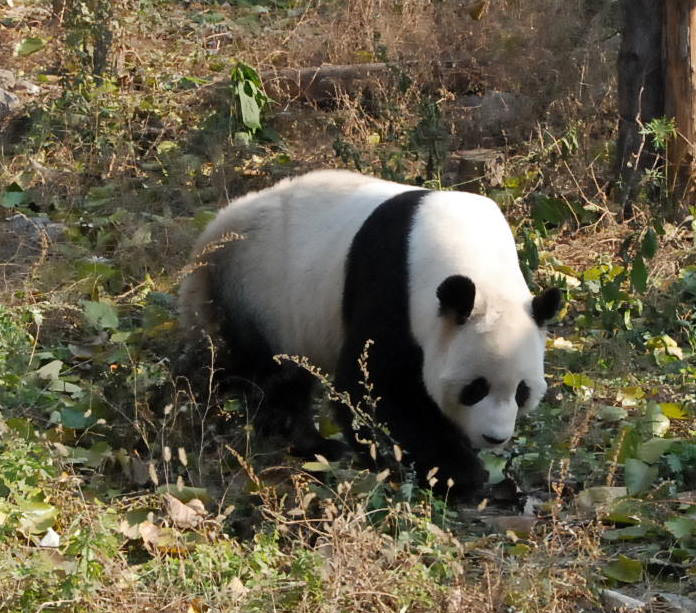

In [5]:
# Open image
img = Image.open('img.jpg')
img

In [6]:
# Preprocess image
tfms = transforms.Compose([transforms.Resize(model.image_size), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),])
img = tfms(img).unsqueeze(0)
img = img.to(torch.device('cuda:0'))

In [7]:
# Load class names
labels_map = json.load(open('labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]

In [8]:
# Classify
model.eval()
with torch.no_grad():
    outputs = model(img).squeeze(0)
print('-----')
for idx in torch.topk(outputs, k=3).indices.tolist():
    prob = torch.softmax(outputs, -1)[idx].item()
    print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))

-----
[464] buckle                                                                      (0.68%)
[715] pickelhaube                                                                 (0.66%)
[79] centipede                                                                   (0.58%)


In [45]:
# Classify
model_new.eval()
with torch.no_grad():
    outputs = model_new(img).squeeze(0)
print('-----')
for idx in torch.topk(outputs, k=3).indices.tolist():
    prob = torch.softmax(outputs, -1)[idx].item()
    print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))

-----
[499] cleaver, meat cleaver, chopper                                              (0.88%)
[450] bobsled, bobsleigh, bob                                                     (0.74%)
[585] hair spray                                                                  (0.73%)


In [46]:
for name, param in model_new.named_parameters():
  print(name)
  print(param.data)


class_token
tensor([[[ 5.5241e-03,  1.3605e-02, -2.5943e-01, -1.5176e-02,  4.0256e-01,
           4.6956e-02, -7.6992e-03,  1.1583e-02,  4.1794e-02, -2.2618e-01,
          -8.6113e-03, -1.3967e-02, -1.5123e-02, -1.3010e-02, -2.0492e-02,
          -8.5839e-03,  3.3414e-03,  5.7678e-02,  3.6365e-02, -5.6758e-03,
          -4.7974e-02,  5.9637e-03, -5.0221e-03, -1.3371e-02, -6.9871e-03,
           5.0253e-02,  7.3932e-03, -5.7437e-03,  2.1240e-02, -1.8942e-02,
           1.5181e-03,  2.5193e-02, -2.0468e-02,  1.6701e-02,  1.9216e-02,
          -9.3600e-04,  5.2248e-02,  9.3180e-03, -4.8390e-03,  1.8174e-03,
           1.4953e-02,  1.0364e-02,  1.7181e-02, -2.5523e-03,  6.5110e-02,
           4.3907e-01,  1.6787e-02,  4.5343e-03,  1.9626e-02, -1.3791e-03,
          -5.4258e-03, -4.4043e-02,  3.1062e-03, -1.2638e-02,  8.5818e-03,
          -7.1245e-03,  9.0131e-04, -2.6523e-03,  5.1280e-03, -7.6498e-02,
           6.5924e-04,  2.2964e-03,  7.7230e-03,  1.2007e-02,  4.1369e-02,
           1.